In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 600000)

In [3]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 500000)

In [4]:
Kdd_path = "./Dataset/kdd99_extracted.csv"
kdd99_df = pd.read_csv(Kdd_path, header=None,names= col_names, nrows= 400000)

kdd99_nor = kdd99_df[kdd99_df['label'] == 'Normal']
kdd99_abnor = kdd99_df[kdd99_df['label'] != 'Normal']

In [5]:
Train_nor_kdd99, Test_nor_kdd99 = train_test_split(kdd99_nor, test_size=0.3, random_state=1)
Train_abnor_kdd99, Test_abnor_kdd99 = train_test_split(kdd99_abnor, test_size=0.3, random_state=1) 

Train_kdd99 = pd.concat([Train_nor_kdd99, Train_abnor_kdd99], ignore_index=True)
Test_kdd99 = pd.concat([Test_nor_kdd99, Test_abnor_kdd99], ignore_index=True)

In [6]:
#Test ver 1: 4 classes attacks
Abnor_df_v1 = Abnor_df[Abnor_df['label'].isin(['FoT', 'DoS', 'DoS_Gas','BP'])]

#Test Ver 2:3 classes attacks
Abnor_df_v2 = Abnor_df[Abnor_df['label'].isin(['BP', 'DoS', 'DoS_Gas'])]

#Test ver 3: 2 classes attacks
Abnor_df_v3 = Abnor_df[Abnor_df['label'].isin(['BP', 'DoS'])]

#Test ver 4: 1 class attack
Abnor_df_v4 = Abnor_df[Abnor_df['label'].isin(['DoS'])]


In [7]:
Train_nor, Test_nor = train_test_split(Nor_df, test_size=0.2, random_state=1)
Train_abnor, Test_abnor = train_test_split(Abnor_df, test_size=0.2, random_state=1) 

Train = pd.concat([Train_nor, Train_abnor], ignore_index=True)
Test = pd.concat([Test_nor, Test_abnor], ignore_index=True)

In [8]:
Train_4classes = Train_abnor[Train_abnor['label'].isin(['FoT', 'DoS', 'DoS_Gas','BP'])]

Train_3classes = Train_abnor[Train_abnor['label'].isin(['DoS', 'DoS_Gas','BP'])]

Train_2classes = Train_abnor[Train_abnor['label'].isin(['DoS','BP'])]

Train_1class = Train_abnor[Train_abnor['label'].isin(['DoS'])]

In [26]:
# Train_kdd = pd.concat([kdd99_nor.iloc[:8000],kdd99_abnor.iloc[:8000]], ignore_index=True)
# Train_nor_kdd = kdd99_nor.iloc[:8000]
# Train_abnor_kdd = kdd99_abnor.iloc[:8000]

# Test_kdd = pd.concat([kdd99_nor.iloc[-2000:],kdd99_abnor.iloc[-2000:]], ignore_index=True)
# Test_nor_kdd = kdd99_nor.iloc[-2000:]
# Test_abnor_kdd = kdd99_abnor.iloc[-2000:]

In [6]:
# Train = pd.concat([Nor_df.iloc[:8000], Abnor_df.iloc[:8000]], ignore_index=True)
# Train_nor = Nor_df.iloc[:8000]
# Train_abnor = Abnor_df.iloc[:8000]

# Test = pd.concat([Nor_df.iloc[-2000:], Abnor_df.iloc[-2000:]], ignore_index=True)
# Test_nor = Nor_df.iloc[-2000:]
# Test_abnor = Abnor_df.iloc[-2000:]

In [9]:
def one_hot_encode(data):
    unique_labels = [
    ["tcp", "udp", "icmp"],
    ["other", "private", "ecr_i", "urp_i", "urh_i", "red_i", "eco_i", "tim_i", "oth_i", "domain_u", "tftp_u", "ntp_u", "IRC", 
                "X11", "Z39_50", "aol", "auth", "bgp", "courier", "csnet_ns", "ctf", "daytime", "discard", "domain", "echo", "efs", "exec", 
                "finger", "ftp", "ftp_data", "gopher", "harvest", "hostnames", "http", "http_2784", "http_443", "http_8001", "icmp", "imap4",
                "iso_tsap", "klogin", "kshell", "ldap", "link", "login", "mtp", "name", "netbios_dgm", "netbios_ns", "netbios_ssn", "netstat",
                "nnsp", "nntp", "pm_dump", "pop_2", "pop_3", "printer", "remote_job", "rje", "shell", "smtp", "sql_net", "ssh", "sunrpc", 
                "supdup", "systat", "telnet", "time", "uucp", "uucp_path", "vmnet", "whois"],
    ["SF", "S0", "S1", "S2", "S3", "REJ", "RSTOS0", "RSTO", "RSTR", "SH", "RSTRH", "SHR", "OTH"],
    ["Normal","OaU","DoS","DoS_Gas","FoT","BP"]
    ]
    encoded_data = []
    # Thực hiện mã hóa one-hot
    for row in data:
        encoding = []
        for i, column_value in enumerate(row):
            unique_column_values = unique_labels[i]
            encoding.extend([1 if column_value == unique else 0 for unique in unique_column_values])
        encoded_data.append(encoding)
    return np.array(encoded_data)

In [10]:
encoder = OneHotEncoder( handle_unknown='ignore')
scaler = MinMaxScaler()

In [11]:
def preprocess_test(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    #df = df.drop(["label"], axis=1)
    df = df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    categorical_data = one_hot_encode(categorical_data)

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [12]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df = df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [13]:
#Dùng hàm preprocess_test
Train_nor = preprocess_test(Train_nor, True)
Train_abnor = preprocess_test(Train_abnor, False)

In [14]:
Train_nor['data'].shape , Train_abnor['data'].shape

((480000, 106), (293936, 106))

In [15]:
test = preprocess_test(Test, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [16]:
Test_nor.shape , Test_abnor.shape

((120000, 106), (73484, 106))

In [31]:
Train_nor = preprocess(Train_nor, True)

In [32]:
Train_abnor = preprocess(Train_abnor, False)

In [17]:
Train_abnor_4clss = preprocess_test(Train_4classes, False)

Train_abnor_3clss = preprocess_test(Train_3classes, False)

Train_abnor_2clss = preprocess_test(Train_2classes, False)

Train_abnor_1clss = preprocess_test(Train_1class, False)

In [18]:
Train_abnor_2clss['data'].shape

(100415, 106)

In [19]:
Test_4class =  Test[Test['label'].isin(['FoT','DoS_Gas','DoS','BP','Normal'])]

Test_3class =  Test[Test['label'].isin(['DoS_Gas','DoS','BP','Normal'])]

Test_2class =  Test[Test['label'].isin(['DoS','BP','Normal'])]

Test_1class =  Test[Test['label'].isin(['DoS','Normal'])]

In [20]:
Test_3class['label'].unique()

array(['Normal', 'BP', 'DoS_Gas', 'DoS'], dtype=object)

In [16]:
#Full classes
test = preprocess(Test, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [32]:
#Trường hợp 4 classes
test = preprocess_test(Test_4class, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [39]:
#Trường hợp 3 classes
test = preprocess_test(Test_3class, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [ ]:
#Trường hợp 2 classes
test = preprocess(Test_2class, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [ ]:
#Trường hợp 1 class
test = preprocess(Test_1class, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [194]:
# chia dữ liệu
# Train_nor = train['data'][train['label'] == 'Normal']
# Train_abnor = train['data'][train['label'] == 'Abnormal']

# Test_nor = test['data'][test['label'] == 'Normal']
# Test_abnor = test['data'][test['label'] == 'Abnormal']

# train_kdd_nor = train_kdd['data'][train_kdd['label'] == 'Normal']
# train_kdd_abnor = train_kdd['data'][train_kdd['label'] == 'Abnormal']

# test_kdd_nor = test_kdd['data'][test_kdd['label'] == 'Normal']
# test_kdd_abnor = test_kdd['data'][test_kdd['label'] == 'Abnormal']


In [21]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      keras.layers.Dense(106, activation='tanh'),
      keras.layers.Dense(52, activation='tanh'),
      keras.layers.Dense(26, activation='tanh'),
      keras.layers.Dense(13, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(13, activation='tanh'),
      keras.layers.Dense(26, activation='tanh'),
      keras.layers.Dense(52, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [22]:
model = Autoencoder(Train_nor['data'].shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [25]:
model.fit(Train_nor['data'], Train_nor['data'], batch_size=128, epochs=1000, shuffle=True)

Epoch 1/1000
3750/3750 [==============================] - 10s 2ms/step - loss: 8.3420e-06
Epoch 2/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.3246e-06
Epoch 3/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.3169e-06
Epoch 4/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.3080e-06
Epoch 5/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.2518e-06
Epoch 6/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.2429e-06
Epoch 7/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.2249e-06
Epoch 8/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.2027e-06
Epoch 9/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.1907e-06
Epoch 10/1000
3750/3750 [==============================] - 8s 2ms/step - loss: 8.1678e-06
Epoch 11/1000
3750/3750 [==============================] - 9s 2ms/step - loss: 8.1594e-06
Epoch 12/1000
3750

In [23]:
#model.save('Model/AE_fullclassn_1200_new.model', save_format='tf')  # The file needs to end with the .keras extension

model_path = 'Model/AE_fullclassn_1200_new.model'
model.load_weights(model_path)

In [24]:
train_normal_re = model.get_reconstruction_error(Train_nor['data'])
train_abnormal_re = model.get_reconstruction_error(Train_abnor['data'])

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

2297/2297 [==============================] - 4s 2ms/step


In [25]:
sigma = 5
alpha = 0.5

In [26]:
sigma_threshold = np.percentile(train_normal_re, 100 - sigma)
sigma_threshold

3.6521286915558435e-06

In [27]:
alpha = 0.5
threshold = np.concatenate([train_normal_re,train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được:', threshold)

Ngưỡng vừa tìm được: 0.00022175040794536471


In [88]:
tf.reduce_min(train_abnormal_re)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7845326e-07>

In [86]:
new_threshold = (tf.reduce_max(train_normal_re) + tf.reduce_min(train_abnormal_re))/2
new_threshold

<tf.Tensor: shape=(), dtype=float32, numpy=0.047117665>

In [54]:
new_threshold2 = 0.00004

In [30]:
from sklearn.metrics import classification_report

8750/8750 [==============================] - 16s 2ms/step
Độ chính xác tập huấn luyện: 0.9873035260840217
3751/3751 [==============================] - 9s 2ms/step
Độ chính xác tập test: 0.9874417713185724
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99    225108
    Abnormal       0.94      1.00      0.97     54891

    accuracy                           0.99    279999
   macro avg       0.97      0.99      0.98    279999
weighted avg       0.99      0.99      0.99    279999

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     96476
    Abnormal       0.94      1.00      0.97     23525

    accuracy                           0.99    120001
   macro avg       0.97      0.99      0.98    120001
weighted avg       0.99      0.99      0.99    120001



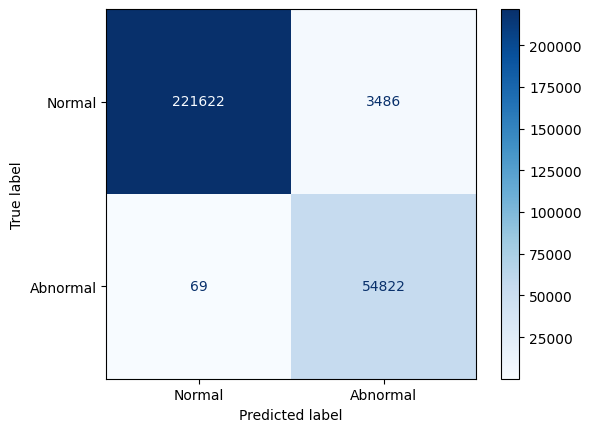

In [22]:
# label_predict = model.predict_class(test_kdd_nor, threshold)
# print('Độ chính xác tập khi tái tạo normal tập huấn luyện', end=': ')
# print(accuracy_score(np.full([2000], 'Normal'), label_predict))

label_predict1 = model.predict_class(train_kdd['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(train_kdd['label'], label_predict1))

label_predict = model.predict_class(test_kdd['data'], threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(test_kdd['label'], label_predict))

labels = ['Normal', 'Abnormal']

matrix2 = confusion_matrix(train_kdd['label'], label_predict1)
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=matrix2, display_labels=labels)

disp1.plot(cmap=plt.cm.Blues)

matrix = confusion_matrix(test_kdd['label'], label_predict)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=labels)

#disp.plot(cmap=plt.cm.Blues)
print(classification_report(train_kdd['label'],label_predict1,target_names=labels))
print(classification_report(test_kdd['label'],label_predict,target_names=labels))

In [28]:
Train_nor['data']
train = np.concatenate((Train_nor['data'], Train_abnor['data']), axis=0)
label = np.concatenate((Train_nor['label'], Train_abnor['label']), axis=0)

In [29]:
train.shape , label.shape

((773936, 106), (773936,))

24186/24186 [==============================] - 34s 1ms/step
Độ chính xác tập huấn luyện với full class: 0.7263300841413244
6047/6047 [==============================] - 9s 1ms/step
Độ chính xác tập test với full class: 0.7262409294825412
              precision    recall  f1-score   support

      Normal       0.82      0.36      0.50    293936
    Abnormal       0.71      0.95      0.81    480000

    accuracy                           0.73    773936
   macro avg       0.76      0.66      0.66    773936
weighted avg       0.75      0.73      0.69    773936

              precision    recall  f1-score   support

      Normal       0.81      0.36      0.50     73484
    Abnormal       0.71      0.95      0.81    120000

    accuracy                           0.73    193484
   macro avg       0.76      0.66      0.66    193484
weighted avg       0.75      0.73      0.69    193484



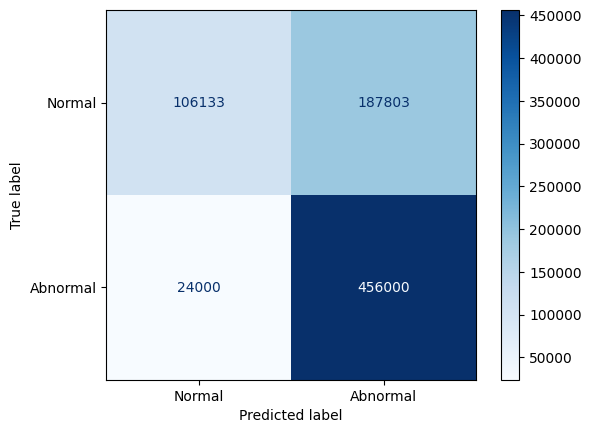

In [31]:
# label_predict = model.predict_class(Test_nor, threshold)
# print('Độ chính xác tập khi tái tạo normal tập huấn luyện', end=': ')
# print(accuracy_score(np.full([2000], 'Normal'), label_predict))

label_predict1 = model.predict_class(train, sigma_threshold)
print('Độ chính xác tập huấn luyện với full class', end=': ')
print(accuracy_score(label, label_predict1))

label_predict = model.predict_class(test['data'], sigma_threshold)
print('Độ chính xác tập test với full class', end=': ')
print(accuracy_score(test['label'], label_predict))

labels = ['Normal', 'Abnormal']

matrix2 = confusion_matrix(label, label_predict1)
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=matrix2, display_labels=labels)

disp1.plot(cmap=plt.cm.Blues)
print(classification_report(label,label_predict1,target_names=labels))
print(classification_report(test['label'],label_predict,target_names=labels))

24186/24186 [==============================] - 31s 1ms/step
Độ chính xác tập huấn luyện với full class: 0.6536625767505323
6047/6047 [==============================] - 7s 1ms/step
Độ chính xác tập test với full class: 0.6532788240888135
              precision    recall  f1-score   support

      Normal       0.99      0.09      0.16    293936
    Abnormal       0.64      1.00      0.78    480000

    accuracy                           0.65    773936
   macro avg       0.82      0.54      0.47    773936
weighted avg       0.77      0.65      0.55    773936

              precision    recall  f1-score   support

      Normal       0.98      0.09      0.16     73484
    Abnormal       0.64      1.00      0.78    120000

    accuracy                           0.65    193484
   macro avg       0.81      0.54      0.47    193484
weighted avg       0.77      0.65      0.55    193484



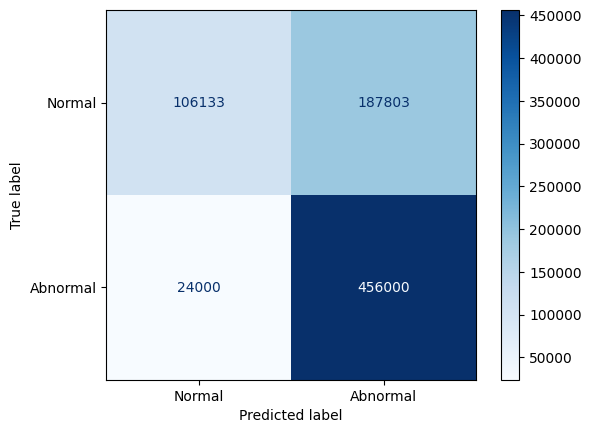

In [33]:
label_predict1 = model.predict_class(train, threshold)
print('Độ chính xác tập huấn luyện với full class', end=': ')
print(accuracy_score(label, label_predict1))

label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test với full class', end=': ')
print(accuracy_score(test['label'], label_predict))

labels = ['Normal', 'Abnormal']

# matrix2 = confusion_matrix(label, label_predict1)
# disp1 = ConfusionMatrixDisplay(
#     confusion_matrix=matrix2, display_labels=labels)

disp1.plot(cmap=plt.cm.Blues)
print(classification_report(label,label_predict1,target_names=labels))
print(classification_report(test['label'],label_predict,target_names=labels))

In [36]:
label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test với 1 class', end=': ')
print(accuracy_score(test['label'], label_predict))


5101/5101 [==============================] - 7s 1ms/step
Độ chính xác tập test với 1 class: 0.8275095123430694


In [30]:
input_re = tf.concat([train_normal_re,train_abnormal_re], axis = 0)
input_re.shape , input_re

(TensorShape([773936]),
 <tf.Tensor: shape=(773936,), dtype=float32, numpy=
 array([2.2290631e-07, 4.4825228e-07, 8.5160046e-08, ..., 9.7739249e-03,
        1.0615976e-07, 1.2387597e-05], dtype=float32)>)

In [31]:
label_mapping = {"Normal": 0, "Abnormal": 1}
label_z = [label_mapping[label] for label in label]
label_z = np.array(label_z)

In [34]:
def custom_loss(y_true, y_pred,input_re):
    predicted_prob = tf.sigmoid(input_re - y_pred)
    loss = keras.losses.binary_crossentropy(y_true, predicted_prob)
    return loss

In [33]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
class ThresholdLayer(Layer):
    def __init__(self, init_threshold, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)
        self.threshold = tf.Variable(initial_value=init_threshold, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        return inputs * self.threshold


In [65]:
input_layer = keras.layers.Input(shape=(1,), name="input_re")
x = Dense(32, activation='relu',kernel_initializer='he_normal')(input_layer)
x = Dense(16, activation='relu',kernel_initializer='he_normal')(x)
x = Dense(8, activation='relu',kernel_initializer='he_normal')(x)
x = Dense(1, activation='sigmoid',kernel_initializer='he_normal')(x)
threshold_layer_output = ThresholdLayer(init_threshold=sigma_threshold)(x)

nn = keras.Model(inputs=input_layer, outputs=threshold_layer_output)
# nn.compile(optimizer='adam', loss=create_custom_loss(input_re),metrics = 'accuracy')


In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [70]:
EPOCHS = 50
BATCH_SIZE = 128
best_accuracy = 0.0

In [68]:
model_path = 'Model/ThresholdNN_50.model'
nn.load_weights(model_path)

In [69]:
sigma_threshold

3.6521286915558435e-06

In [71]:
for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0

    all_predictions = []
    all_labels = []

    for batch_start in range(0, len(input_re), BATCH_SIZE):
        batch_end = batch_start + BATCH_SIZE
        x_batch = input_re[batch_start:batch_end]
        y_batch = label_z[batch_start:batch_end]
        #y_batch2 = label[batch_start:batch_end]
        with tf.GradientTape() as tape:
            predictions = nn(x_batch, training=True)
            batch_loss = custom_loss(y_batch, predictions, x_batch)
        # print(predictions)
        grads = tape.gradient(batch_loss, nn.trainable_weights)
        optimizer.apply_gradients(zip(grads, nn.trainable_weights))

        total_loss += batch_loss.numpy().mean()
        num_batches += 1
    
    threshold_0 = nn(np.mean(input_re).reshape(1,-1))
    avg_train_loss = total_loss / num_batches

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_train_loss}, Threshold: {threshold_0.numpy()}")




Epoch 1/50, Loss: 0.3052265968264649, Threshold: [[0.0037287]]
Epoch 2/50, Loss: 0.4081306467187759, Threshold: [[0.00375561]]
Epoch 3/50, Loss: 0.408538351564487, Threshold: [[0.00378349]]
Epoch 4/50, Loss: 0.4085944457092178, Threshold: [[0.00380099]]
Epoch 5/50, Loss: 0.4087648740251893, Threshold: [[0.00382949]]
Epoch 6/50, Loss: 0.4089267496573667, Threshold: [[0.00377855]]
Epoch 7/50, Loss: 0.40918508662952874, Threshold: [[0.00383777]]
Epoch 8/50, Loss: 0.4089164054610343, Threshold: [[0.00382709]]
Epoch 9/50, Loss: 0.4088102550777093, Threshold: [[0.00386382]]


KeyboardInterrupt: 

In [40]:
nn.save('Model/ThresholdNN_100.model', save_format='tf')  # The file needs to end with the .keras extension


INFO:tensorflow:Assets written to: Model/ThresholdNN_100.model\assets


INFO:tensorflow:Assets written to: Model/ThresholdNN_100.model\assets


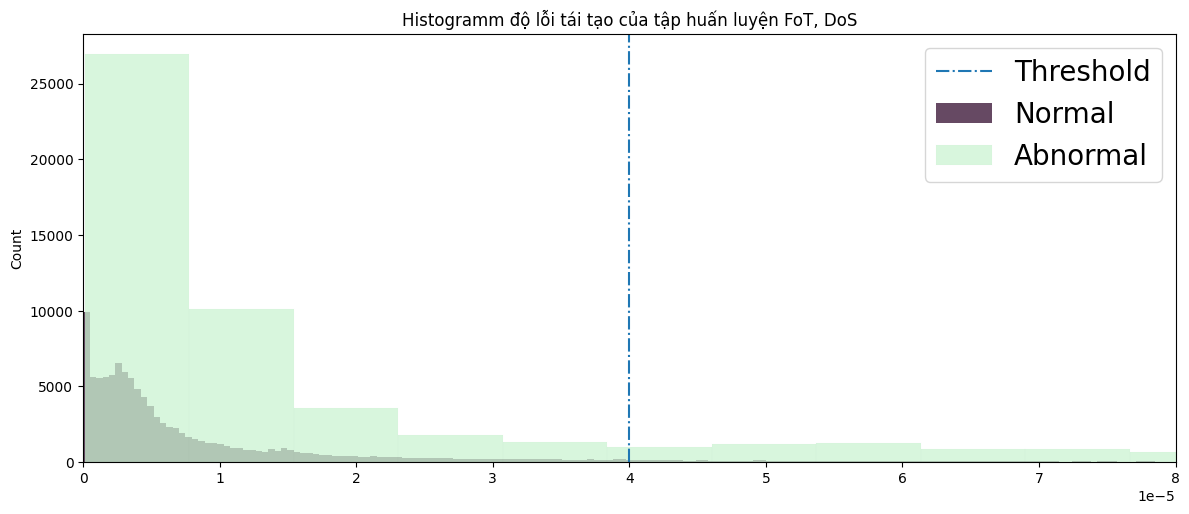

In [56]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(new_threshold2, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.00008])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện FoT, DoS')
plt.show()

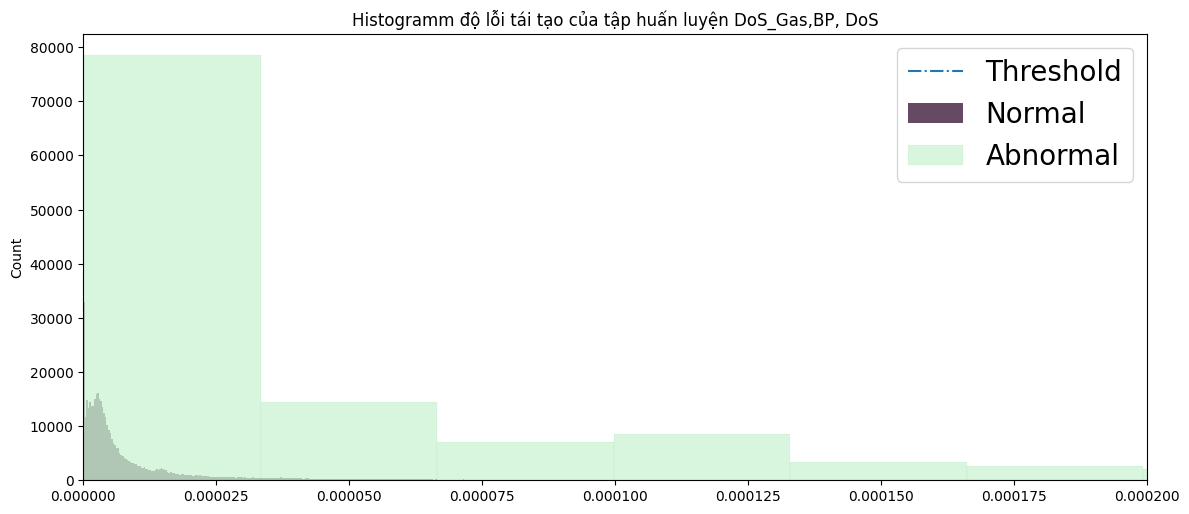

In [85]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.0002])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện DoS_Gas,BP, DoS')
plt.show()
#threshold = 0.00069

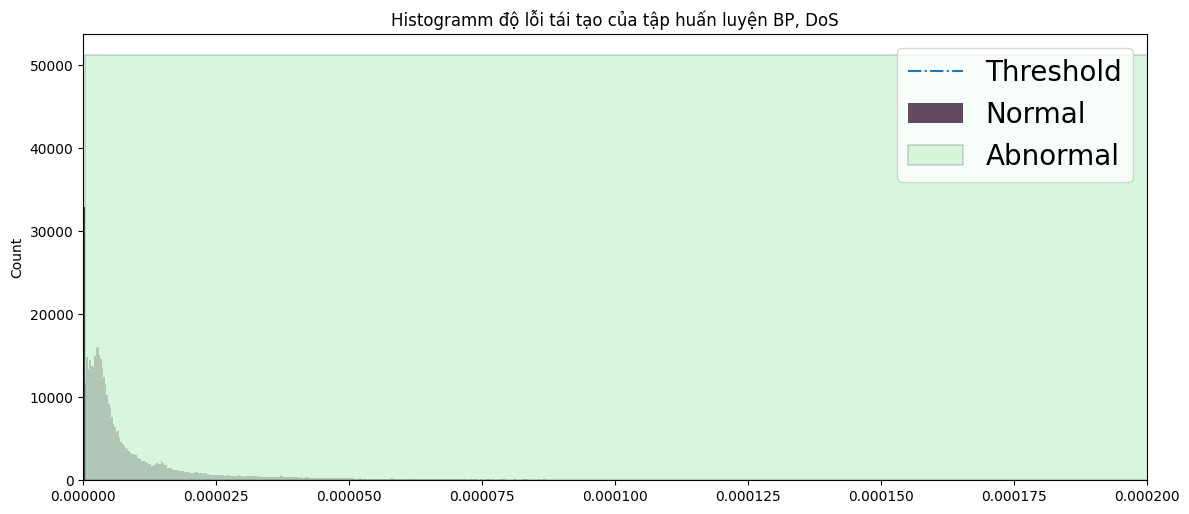

In [100]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.0002])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện BP, DoS')
plt.show()
#threshold = 0.00077

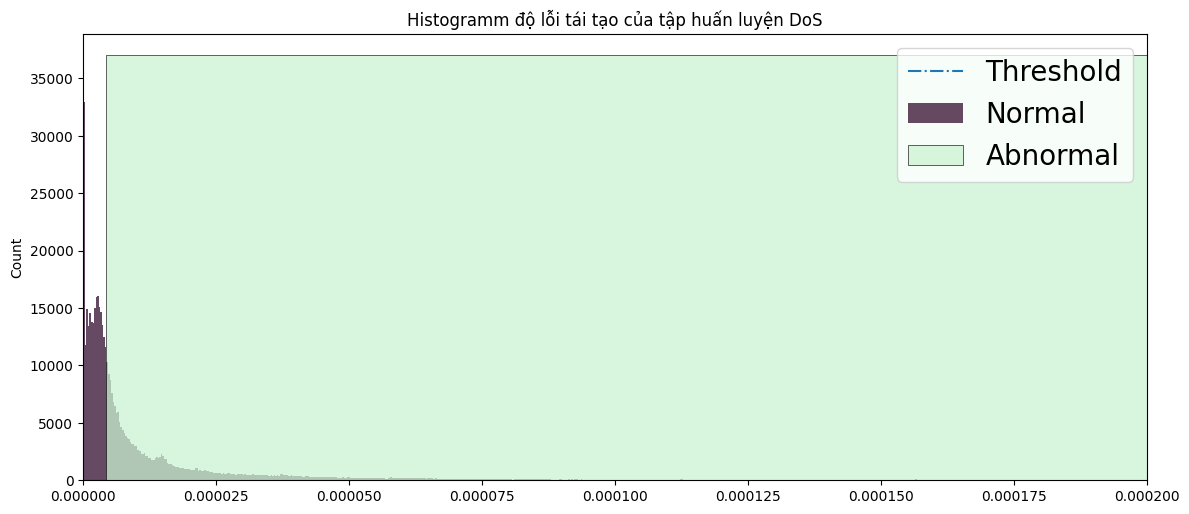

In [111]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.0002])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện DoS')
plt.show()
#threshold = 0.0008

In [13]:
from sklearn import svm 

In [26]:
clf = svm.SVC(kernel='linear')
clf2 = svm.OneClassSVM(kernel='rbf', gamma='auto')

In [16]:
clf.fit(train,label)

SVC(kernel='linear')

In [17]:
y_pred = clf.predict(test['data'])

In [18]:
accuracy = accuracy_score(test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.900975


In [29]:
clf2.fit(Train_nor['data'])

OneClassSVM(gamma='auto')

In [33]:
y_pred3 = clf2.predict(test['data'])

In [34]:
y_pred_strings = np.where(y_pred3 == -1, "Abnormal", "Normal")
accuracy4 = accuracy_score(test['label'], y_pred_strings)
print(accuracy4)

0.57305


In [32]:
y_pred_strings = np.where(y_pred3 == -1, "Abnormal", "Normal")
accuracy3 = accuracy_score(label, y_pred_strings)
print(accuracy3)

0.57553125
